praca wykonana na podstawie:
https://www.youtube.com/watch?v=a4Yfz2FxXiY

Imports

In [3]:
import torch
#from einops import einsum
#from torch import einsum
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from tqdm import tqdm
from torchvision.utils import save_image, make_grid
from torch.optim import Adam
from torchvision import transforms 
from torch.utils.data import DataLoader,random_split , Dataset
from random import randint,random
import os

import math

#from google.colab import drive
#drive.mount('/content/drive')

device = "cuda" if torch.cuda.is_available() else "cpu"

Data-set test

(<PIL.Image.Image image mode=L size=28x28 at 0x1DC32DB0750>, 5)


TypeError: 'Image' object is not subscriptable

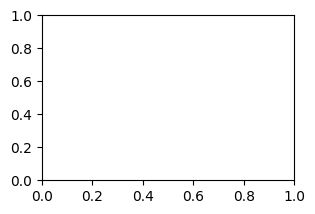

In [ ]:
dataset = torchvision.datasets.MNIST(root=".", download=True)

plt.figure(figsize=(15,15)) 
for i, img in enumerate(dataset):
    print(img)
    if i == 20:
        break
    plt.subplot(6, 4, i + 1)
    plt.imshow(img[0])
    print("sample:" + str(img[1][0]))

In [36]:
# Calculate 
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    """
    Calculates the beta values for each timestep in the range [start, end], for given timesteps.
    """
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device=device):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 500
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [37]:
IMG_SIZE = 32
BATCH_SIZE = 64
TRAIN_SPLIT = 0.9

# class FilteredMNIST(Dataset):
#     def __init__(self, root, transform=None, target_digit=6):
#         self.dataset = torchvision.datasets.MNIST(root=root, download=True, transform=transform)
#         self.target_digit = target_digit
#         self.indices = [i for i, (_, label) in enumerate(self.dataset) if label == self.target_digit]

#     def __len__(self):
#         return len(self.indices)

#     def __getitem__(self, idx):
#         return self.dataset[self.indices[idx]]

def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),# resize to fit 64/64 format 
        transforms.ToTensor(), # Scales data into [0,1] 
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
    ]
    data_transform = transforms.Compose(data_transforms)

    data_samples = torchvision.datasets.MNIST(root=".",download=True,transform=data_transform)
    
    print(data_samples[0])
 
    train_size = int(TRAIN_SPLIT * len(data_samples))
    test_size = len(data_samples) - train_size

    train,test = random_split(data_samples,[train_size,test_size])

    print("Data size: ", len(data_samples))
    print("Train size: ", train_size, " len(train):",len(train))
    print("Test size: ", test_size, " len(test):",len(test))

    return torch.utils.data.ConcatDataset([train,test])

def show_tensor_image(image, ax):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    if len(image.shape) == 4:
        image = image[0, :, :, :]
    ax.imshow(reverse_transforms(image))

data = load_transformed_dataset()
print(data)
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

(tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]]), 5)
Data size:  60000
Train size:  54000  len(train): 54000
Test size:  6000  len(test): 6000


In [1]:
# Simulate forward diffusion
elem = next(iter(dataloader))
image = elem[0]
plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 9
stepsize = int(T/num_images)
ax = plt.gca()
plt.subplot(1, num_images+1, int(0/stepsize) + 1)
show_tensor_image(image, ax)
for idx in range(1, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    print(img[0][0].shape)
    ax = plt.gca()
    show_tensor_image(img[0], ax)

NameError: name 'dataloader' is not defined

In [ ]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        if up:
            self.transform = nn.ConvTranspose2d(2*in_ch, out_ch, 4, 2, 1)
        else:
            self.transform = nn.Conv2d(in_ch, out_ch, 4, 2, 1)
        
        self.conv1 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()

    def forward(self, x, t):
        h = self.transform(x)
        h = self.bnorm1(self.relu(self.conv1(h)))

        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[..., None, None]  # expand to [B, C, 1, 1]
        h = h + time_emb

        h = self.bnorm2(self.relu(self.conv2(h)))
        return h


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    def __init__(self):
        super().__init__()
        image_channels = 1
        down_channels = (32, 64, 128, 256,512)
        up_channels = (512,256, 128 ,64 ,32)  # Account for concat
        out_dim = 1
        time_emb_dim = 32
        num_classes = 10

        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )

        # One-hot embedding
        self.class_emb = nn.Embedding(num_classes, time_emb_dim)

        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        self.downs = nn.ModuleList([
            Block(down_channels[i], down_channels[i+1], time_emb_dim)
            for i in range(len(down_channels)-1)
        ])

        self.ups = nn.ModuleList([
            Block(up_channels[i], up_channels[i+1], time_emb_dim, up=True)
            for i in range(len(up_channels)-1)
        ])

        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep, class_label_onehot):
        # Time + Class embedding
        t = self.time_mlp(timestep)
        c = self.class_emb(class_label_onehot.long())  # now using one-hot
        t = t + c

        x = self.conv0(x)
        residuals = []

        for down in self.downs:
            x = down(x, t)
            residuals.append(x)

        for up in self.ups:
            res = residuals.pop()
            if x.shape[2:] != res.shape[2:]:
                res = F.interpolate(res, size=x.shape[2:])
            x = torch.cat((x, res), dim=1)
            x = up(x, t)
        out = self.output(x)
        return out
    
    def saveModel(self,filename):
        # Ścieżka do folderu na Google Drive (możesz zmienić tę ścieżkę na swoją preferowaną)
        drive_path = "/content/drive/MyDrive/models/"
        
        # Tworzenie folderu, jeśli nie istnieje
        if not os.path.exists(drive_path):
            os.makedirs(drive_path)
        
        # Pełna ścieżka do zapisu
        file_path = os.path.join(drive_path, filename)
        
        # Zapis modelu
        torch.save(self.state_dict(), file_path)

    def loadModel(self,path):
        if path != None:
            model.load_state_dict(torch.load(path))

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))


Num params:  16248769


In [40]:
def get_loss(model, x_0, t, c):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t,c)
    return F.mse_loss(noise, noise_pred)

def get_class_representation(class_numbers, num_classes=10):
    #one_hot = F.one_hot(class_numbers, num_classes=num_classes)
    return torch.tensor(class_numbers,device=device)

sampling

0


C:\Users\piotr\AppData\Local\Temp\ipykernel_3504\2249053712.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(class_numbers,device=device)


1
2
3
4
5
6
7
8
9


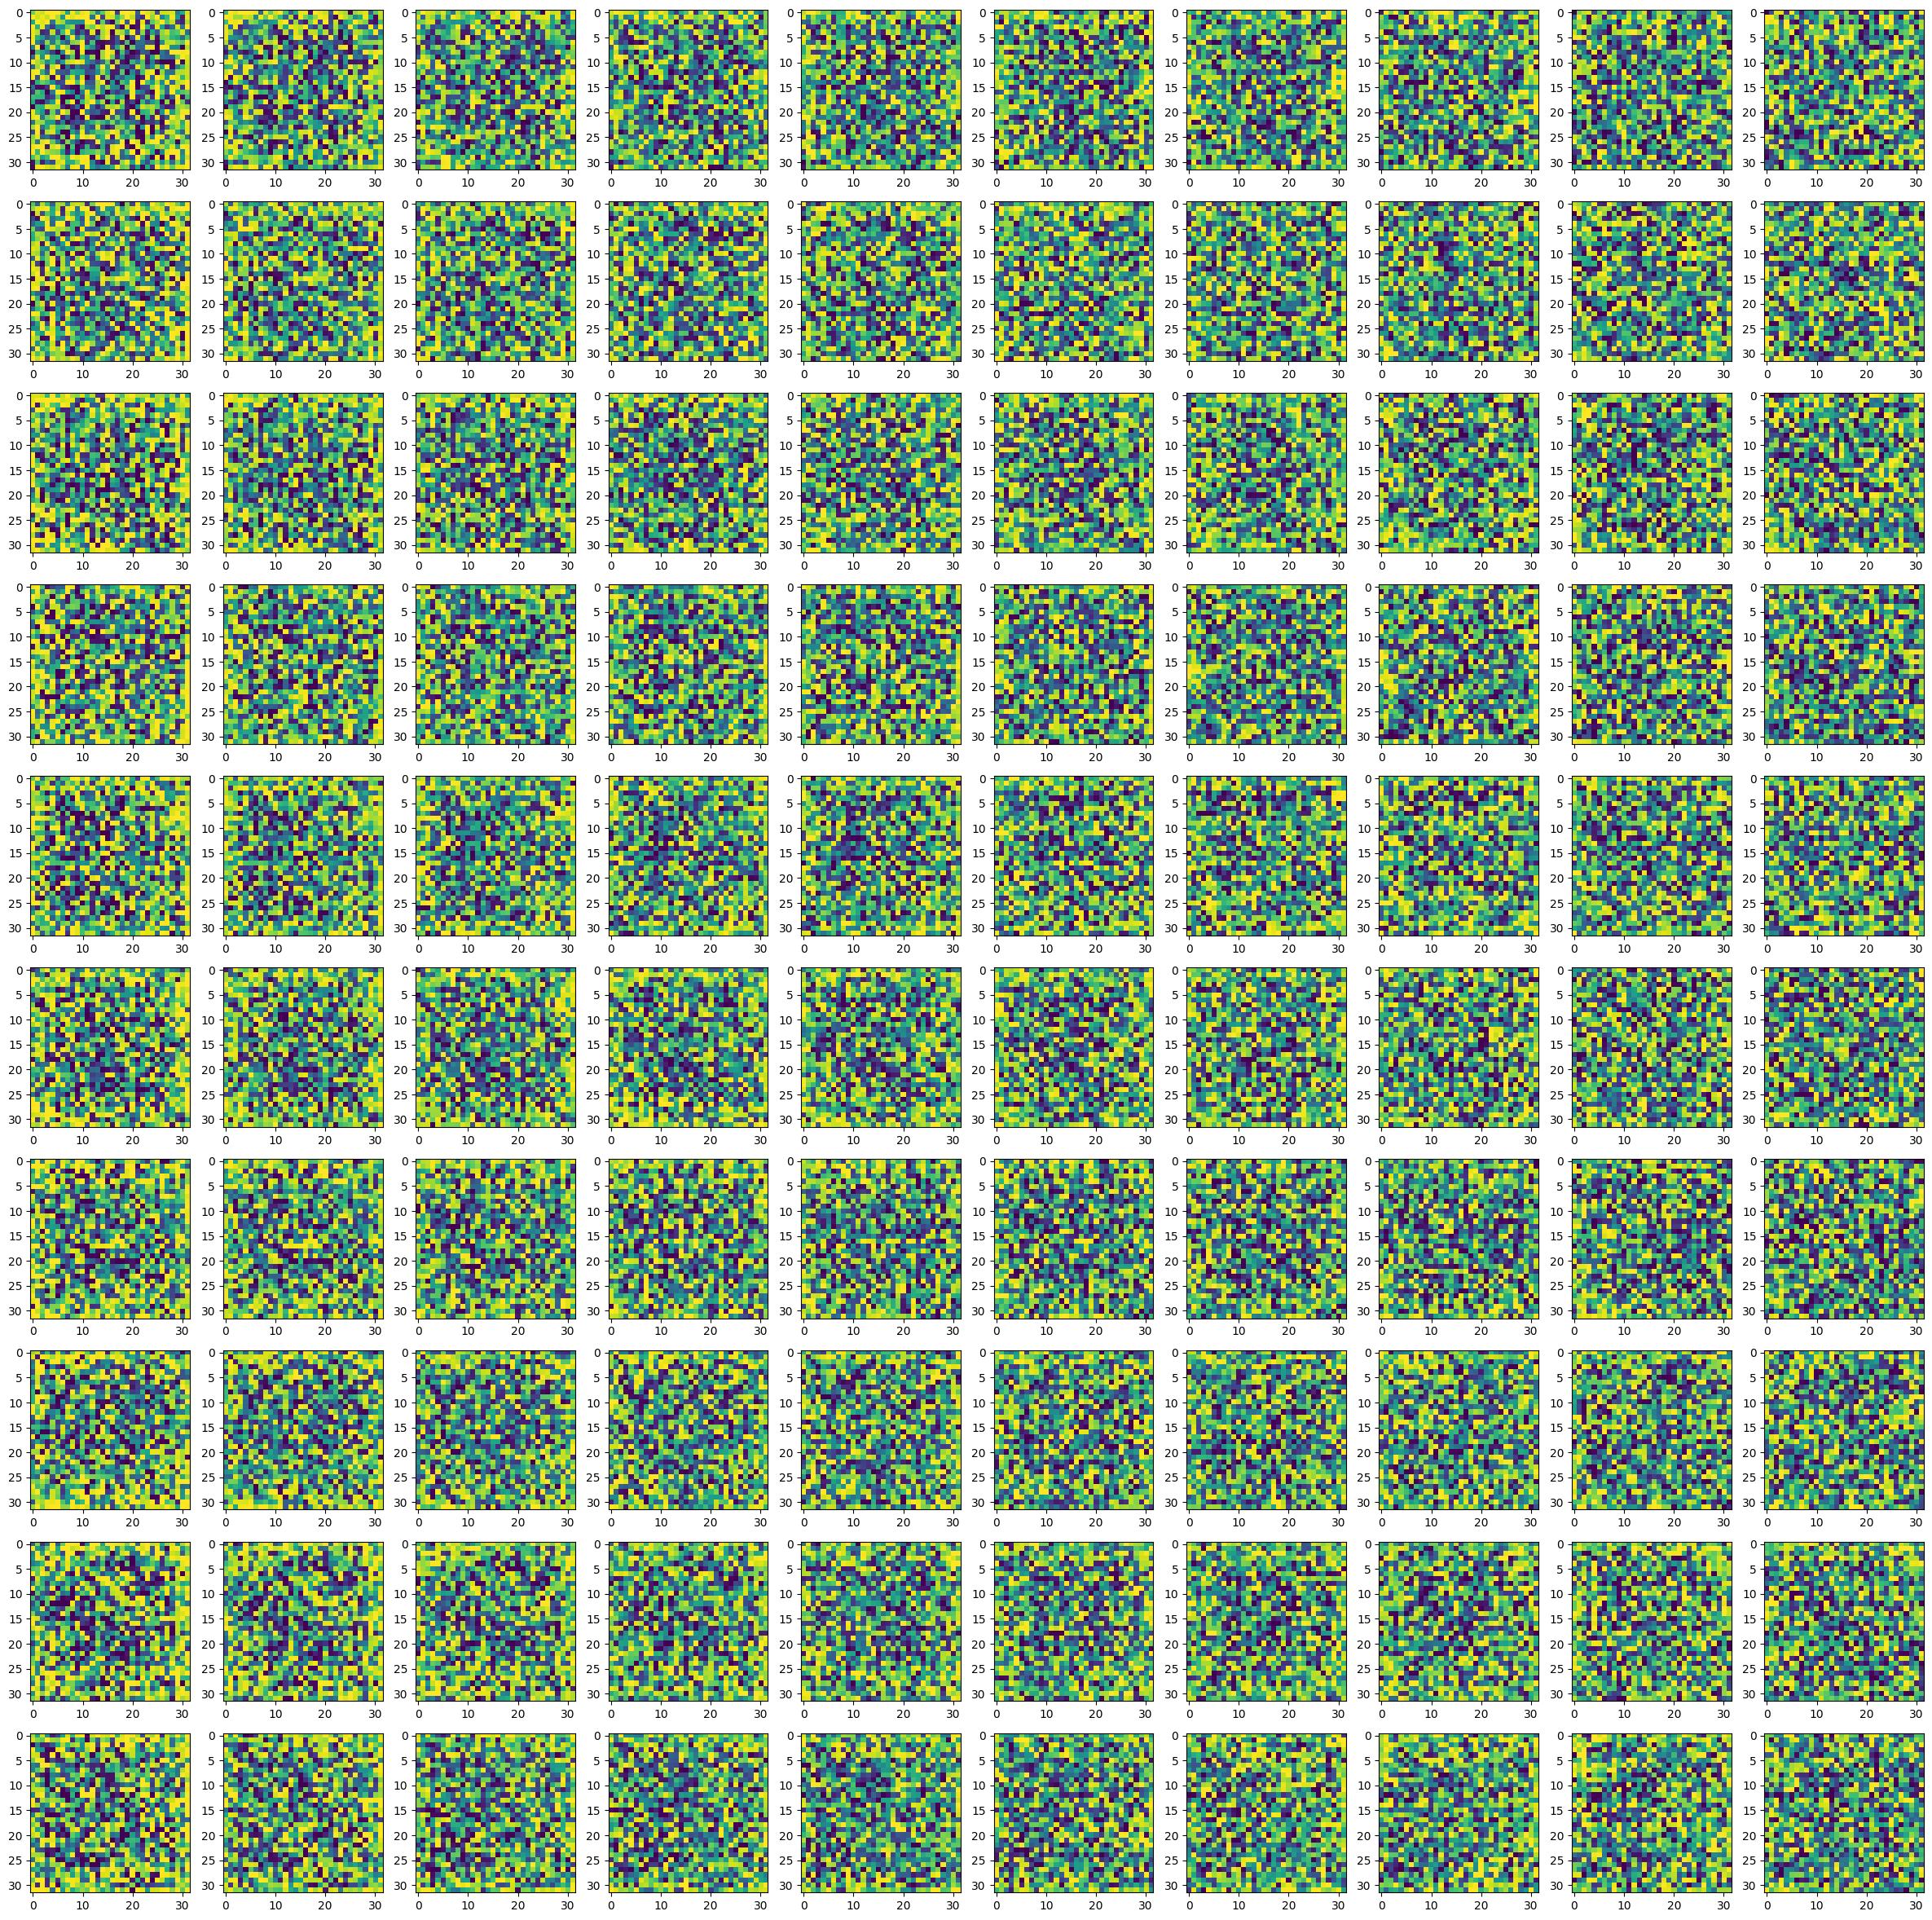

In [41]:
@torch.no_grad()
def sample_timestep(x, t,c_class):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t,c_class) / sqrt_one_minus_alphas_cumprod_t
    )

    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image(num_of_plots = 10,number_to_generate = [0,1,2,3,4,5,6,7,8,9]):
    # Sample noise
    img_size = IMG_SIZE
    num_images = 10
    stepsize = int(T/num_images)
    fig, axes = plt.subplots(num_of_plots, num_images, figsize=(3*num_images, 3*num_of_plots))
    for generetion_number in range(num_of_plots):
        if number_to_generate != None:
            ntg = number_to_generate[generetion_number]
        else:
            ntg = randint(0,9)
        print(ntg)
        img = torch.randn((1, 1, img_size, img_size))
        img_class = get_class_representation(torch.tensor([ntg]))
        for i in range(0,T)[::-1]:
            t = torch.full((1,), i, dtype=torch.long)
            img = sample_timestep(img, t, img_class)
            img = torch.clamp(img, -1.0, 1.0)
            if i % stepsize == 0:
                plot_idx = int(i / stepsize)
                ##print(f"Adding subplot [{generetion_number}, {plot_idx}]")
                if num_of_plots == 1:
                    ax = axes[plot_idx]
                else:
                    ax = axes[generetion_number, plot_idx]
                show_tensor_image(img.detach().cpu(), ax)
    plt.show()

#model.loadModel("FULL_diffusal_model_130")
sample_plot_image()

Training

Epoch 0


c:\Users\piotr\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


0


C:\Users\piotr\AppData\Local\Temp\ipykernel_3504\2249053712.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(class_numbers,device=device)


1
2
3
4
5
6
7
8
9


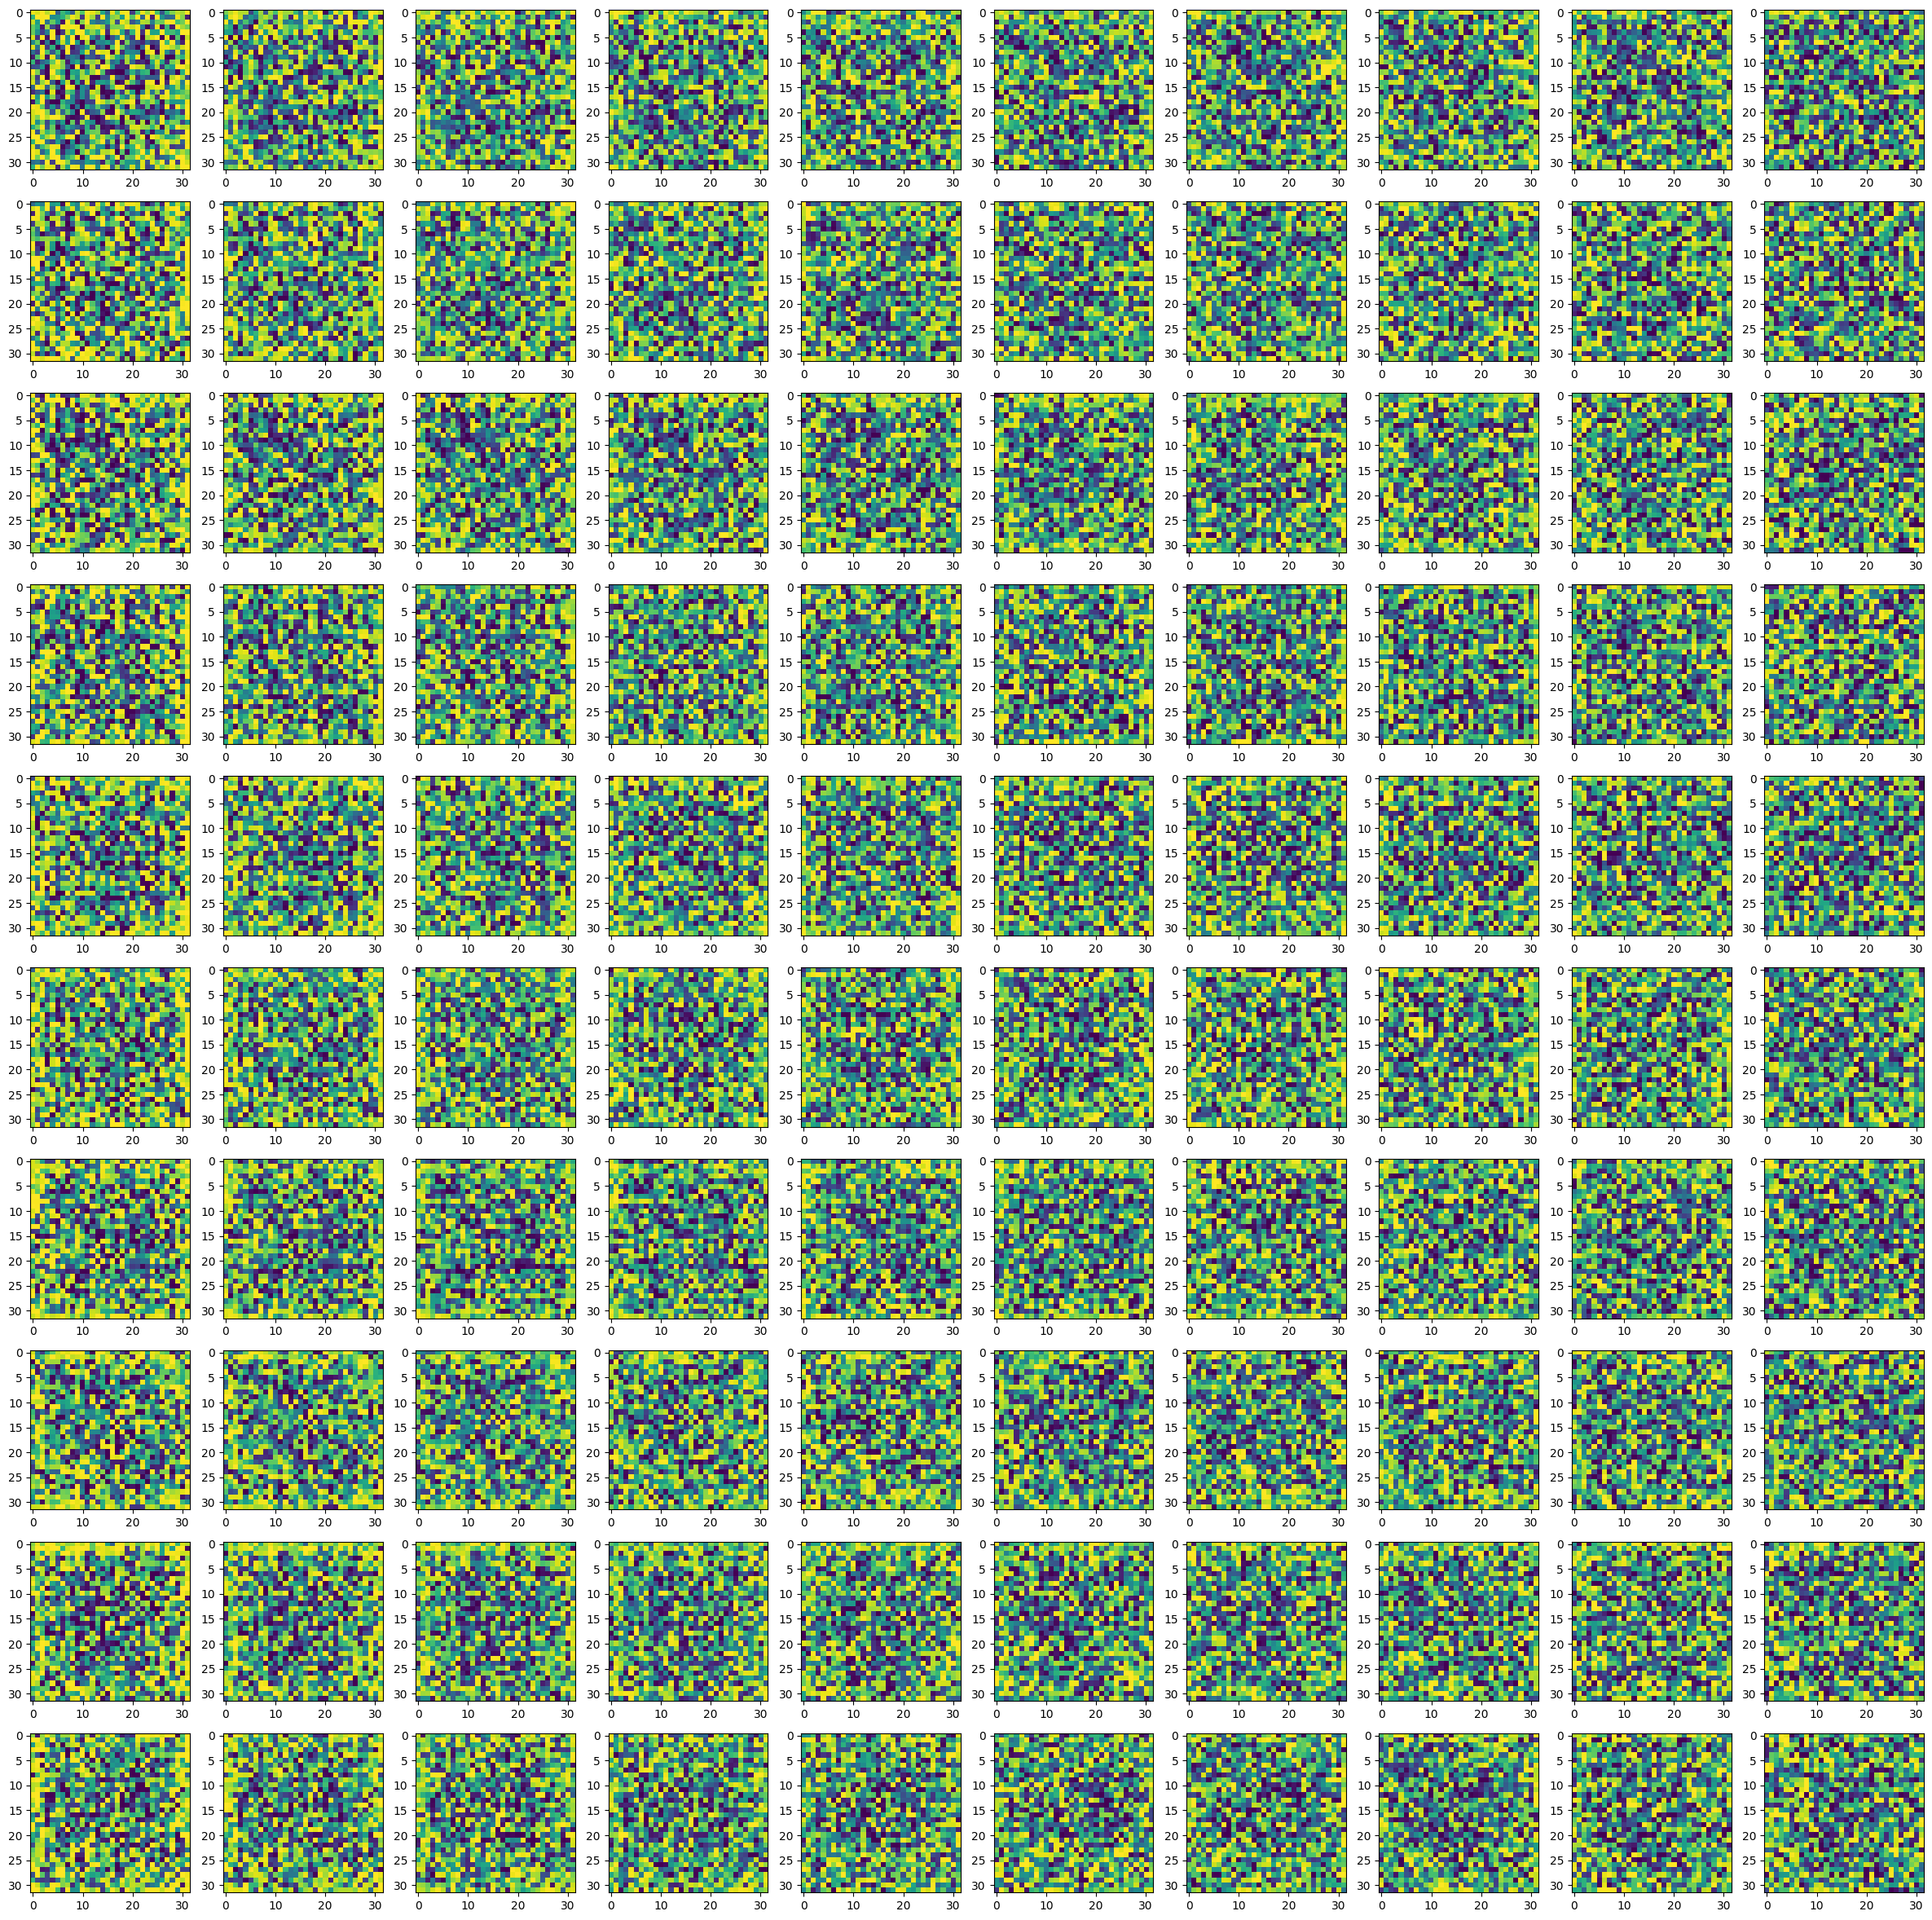

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

#model.loadModel("/content/drive/MyDrive/models/model_epoch_25.pth")
model.to(device)

optimizer = Adam(model.parameters(), lr=0.0001)
epochs = 300 # Try more!

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
loss = torch.tensor([[0]])
torch.autograd.set_detect_anomaly(True)
for epoch in range(epochs):
    print(f"Epoch {epoch}")
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()
      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()

      loss = get_loss(model, batch[0], t,get_class_representation(batch[1]))
      loss.backward()
      optimizer.step()
      print(f"Epoch {epoch} | step {step:04d} Loss: {loss.item()} ")
    scheduler.step()

    if epoch % 10 == 0 and step == 0:
      model.saveModel("FULL_diffusal_model_"+str(epoch))
      if (epoch - 1)%(10) != 0 and os.path.exists("FULL_diffusal_model_"+str(epoch-1)):
        os.remove("FULL_diffusal_model_"+str(epoch-1))
      sample_plot_image()
